In [57]:
# import jax.numpy as np
# from jax import grad, value_and_grad, jit, ops
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

import SSN_classes
import SSN_power_spec
import gamma_SSN_losses as losses

from importlib import reload
reload(SSN_classes)
reload(SSN_power_spec)
reload(losses)

<module 'gamma_SSN_losses' from '/Users/cholt/Google Drive/Python/torch_SSN/jax_caleb/gamma_SSN_losses.py'>

In [2]:
#the constant (non-optimized) parameters:

#fixed point algorithm:
dt = 1
xtol = 1e-6
Tmax = 500

#power spectrum resolution and range
fnums = 30
freq_range = [15,100]

#SSN parameters
n = 2
k = 0.04
tauE = 20 # in ms
tauI = 10 # in ms
psi = 0.774

t_scale = 1
tau_s = np.array([3, 5, 100])*t_scale #in ms, AMPA, GABA, NMDA current decay time constants
NMDAratio = 0.4 #NMDA strength as a fraction of E synapse weight

In [33]:
params = np.array([1.7, 1.25, 2.2,  1.5, 1.2]) # [Jee, Jei, Jie, Jii, i2e]
contrasts = np.array([0, 25, 50, 100])
contrasts = np.array([25])

Jee = params[0]
Jei = params[1]
Jie = params[2]
Jii = params[3]
i2e = params[4]

cons = len(contrasts)

J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())

r_init = np.zeros([ssn.N, len(contrasts)])
inp_vec = np.array([[1], [i2e]]) * contrasts

r_fp = ssn.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)

      converged to fixed point at iter=226,      as max(abs(dx./max(xvec,1.0))) < 1e-06 


In [34]:
J = ssn.DCjacobian(r_fp)
for ii in range(len(contrasts)):
    print(J[ii])

[[ 1.5552526  0.         2.5552526  0.         2.5552526  0.       ]
 [ 3.3067973 -1.         3.3067973  0.         3.3067973  0.       ]
 [ 0.        -4.385322  -1.        -4.385322   0.        -4.385322 ]
 [ 0.        -5.262387   0.        -6.262387   0.        -5.262387 ]
 [ 1.7035017  0.         1.7035017  0.         0.7035017  0.       ]
 [ 2.2045317  0.         2.2045317  0.         2.2045317 -1.       ]]


In [35]:
Phi = lambda rr: np.diag(ssn.gains_from_r(rr))
Phi(r_fp[:,1])

array([[1.0302504, 0.       ],
       [0.       , 1.4427818]], dtype=float32)

In [36]:
maxF = freq_range[1]
minF = freq_range[0]
fs = np.linspace(minF,maxF,fnums) # grid of frequencies in Hz
fs = fs/1000 # coverting from Hz to kHz = 1/ms

#AnalPowSpecE = np.empty_like(fs)
#AnalPowSpecE = []
inv_G = np.array([-1j * 2 * np.pi * ff * np.diag(ssn.tau_s_vec) - J[cc] for cc in range(cons) for ff in fs])

In [47]:
eE, noiseCov, SpatialFilt = SSN_power_spec.make_eE_noiseCov(ssn, SSN_power_spec.NoisePars(), [0])
eE = np.kron(np.ones(ssn.num_rcpt), eE)

iGf = np.transpose(inv_G[0].conj())

x = np.linalg.solve(iGf, eE)

In [20]:
import scipy.io as io

In [37]:
io.savemat('pyGf.mat', {'pyGf':inv_G[0]})

In [41]:
x - [1.3349 - 0.2233j,  -0.9178 + 0.2254j,   1.2034 - 0.4129j,  -0.8164 + 0.3506j, 0.0317 - 0.1450j,   -0.0145 + 0.1026j
]

array([ 2.73000380e-05-1.91408786e-05j, -3.63136353e-05+4.86337079e-05j,
        5.19878768e-05-9.07487807e-05j,  5.10040951e-05+3.19455676e-05j,
        3.49892558e-05+2.74275296e-05j, -1.53228081e-06+1.02558009e-05j])

In [42]:
SpatialFilt

DeviceArray(1, dtype=int32)

In [48]:
y = SSN_power_spec.NoisePars()

In [50]:
y.corr_time

5

In [59]:
ideal_spect = io.loadmat("../../../MATLAB/GammaSharedWithCaleb/SSN_2D/standJ19-09-20-BestSpect.mat")

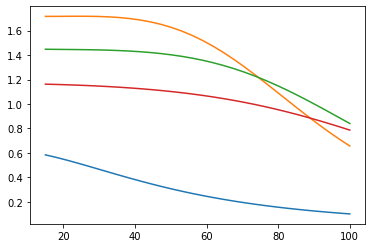

In [58]:
plt.plot(fs*1000, losses.get_target_spect(fs*1000))

In [60]:
ideal_spect['best_spect']

array([[0.60836392+2.83711890e-18j, 2.5129032 +1.17189809e-17j,
        1.75274476+8.17396482e-18j, 1.17802577+5.49374983e-18j],
       [0.60812383+9.59907674e-19j, 2.17913121-1.98550376e-17j,
        1.62897425+2.26054909e-17j, 1.15976606+1.65641210e-18j],
       [0.60740461+2.83264513e-18j, 1.88759696+8.80285112e-18j,
        1.50533878+7.02018142e-18j, 1.13918912+5.31263424e-18j],
       [0.60620934-4.67492613e-18j, 1.76704116+8.24063643e-18j,
        1.44919829-8.24562516e-18j, 1.1288933 +1.27666165e-17j],
       [0.60454312+2.81930053e-18j, 1.71321073+7.98959700e-18j,
        1.42302802+6.63632337e-18j, 1.12379101+5.24082479e-18j],
       [0.60241306+2.80936693e-18j, 1.68573647+7.86147017e-18j,
        1.40934375+2.15670326e-17j, 1.1209592 +5.22761858e-18j],
       [0.59982812+2.79731201e-18j, 1.67018201+7.78893157e-18j,
        1.40144435+2.15236912e-17j, 1.11918875+5.21936205e-18j],
       [0.59679909+2.78318603e-18j, 1.66070048-2.22159788e-17j,
        1.39652431+2.14930693e-17

In [61]:
def param_relu(param, A, acceptable_range):
    '''
    Returns reLU that is 0 in acceptable range, and nonzero outside that range
    acceptable_range = [lower bound, upper bound]
    '''
    return A * (np.maximum(acceptable_range[0] - param, 0) + np.maximum(param - acceptable_range[1], 0))

In [62]:
params = np.array([2.48142314, 1.33481634, 2.41267252, 0.97223365, 1.03279865])

In [67]:
J_range = [0,3]

param_relu(params[3], 10, J_range)

0.0